# Coursera: Deep Learning and Reinforcement Learning Final Project

Q: In this project you will use the tools and techniques you learned throughout this course to use deep learning for a task of your choosing. It can be any Deep Learning application for supervised or unsupervised learning. You **choose to work on a classification, image, or text application** on a data set that you feel passionate about. Then, you will **tweak your deep learning model to best suits your needs**, and communicate insights you found from your model development exercise.

I have chosen a subset of **notMNIST dataset** from Kaggle by Yaroslav Bulatov which is similar to MNIST by extracting glyphs from publicly available fonts. The dataset contains 10 classes, with each class representing a letter from A to J. I will only take the **letters images of letter A** in my project. The sections will inlucde the following:
* Objectives and packages
* Load and inspect notMNIST data
* Generate images with autoencoder
* Generate images with variational autoencoder
* Generate images with GANs
* Summary

## Objectives and packages
### objective:
To apply **unsupervised Deep Learning models** to **learn and generate** letters A of different fonts, based on notMNIST dataset. The studies of each DL models will include the following:
* train DL models based on train set
* Visualize the images of each latent dimension 
* Check the performance to generate image based on test set

### Packges

In [1]:
import warnings
warnings.simplefilter('ignore')

import os
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

from os import listdir
from pathlib import Path
import imghdr

import numpy as np

import tensorflow as tf
# Import the keras library
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.python.client import device_lib
from tensorflow.keras import layers
from tensorflow.keras.layers import Input,Conv2DTranspose,\
BatchNormalization,ReLU,Conv2D,LeakyReLU, MaxPooling2D, Flatten,\
Dense, Reshape,Dropout


from IPython import display
import matplotlib.pyplot as plt

%matplotlib inline

import time
#from tqdm.auto import tqdm
from tqdm import tqdm


2023-04-04 20:34:26.926287: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
tf.config.experimental_run_functions_eagerly(True)
tf.config.run_functions_eagerly(True)


Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


In [3]:
def plot_samples(X,title=""):
    
    plt.rcParams['figure.figsize'] = (15,7) 

    for i,x in enumerate(X[0:8]):
        try:
            x=x.numpy()
        except:
            pass
        max_=x.max()
        min_=x.min()
        
        xnew=np.uint(255*(x-min_)/(max_-min_))
        plt.subplot(2,4,i+1)
        plt.imshow(xnew, cmap = 'inferno')
        plt.axis("off")
    plt.suptitle(title, fontsize = 25)
    plt.subplots_adjust(wspace=0, hspace=0)

    plt.show()


In [4]:
def plot_model_history(history, model = 'Model'):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    ax1.plot(history.history['loss'], label='train_loss')
    ax1.plot(history.history['val_loss'], label='val_loss')
    ax1.set_title(f'{model} Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train_accuracy')
    ax2.plot(history.history['val_accuracy'], label='val_accuracy')
    ax2.set_title(f'{model} Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.show()

In [5]:
# calculate MSE after standardization between true and prediction
def standardized_MSE(X_original, X_pred):
    return np.sum(np.power(X_original - X_pred, 2))/(X_original.shape[0]*X_original.shape[1])

## Load and inspect Data
My notMNST A data is organize as the following:
<pre>
notMNIST_A/
    ├── train/
    |   ├── img1.png
    |   ├── img2.png
    |   ├── ...
    └── test/
        ├── img1.png
        ├── ...
</pre>
even though I am working on unsupervised DL model, I split the data into train and test dataset so that I can check the performance of DL generating images based on test images

In [6]:
img_height, img_width = (28,28)
batch_size = 128
train_ds = tf.keras.utils.image_dataset_from_directory(directory='notMNIST_A/train',
                                                       image_size=(img_height, img_width),
                                                       batch_size=batch_size,
                                                       color_mode="grayscale",
                                                       label_mode=None)
test_ds = tf.keras.utils.image_dataset_from_directory(directory='notMNIST_A/test',
                                                       image_size=(img_height, img_width),
                                                       batch_size=batch_size,
                                                       color_mode="grayscale",
                                                       label_mode=None)


Found 1764 files belonging to 1 classes.
Found 108 files belonging to 1 classes.


2023-04-04 20:34:32.342598: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
normalization_layer = layers.experimental.preprocessing.Rescaling(scale= 1./127.5, offset=-1)
normalized_ds = train_ds.map(lambda x: normalization_layer(x))
normalized_test_ds = test_ds.map(lambda x: normalization_layer(x))


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [8]:
# Get numpy formate of train and test datasets
X_train = np.concatenate(list(train_ds.as_numpy_iterator()), axis=0)/255.
X_test = np.concatenate(list(test_ds.as_numpy_iterator()), axis=0)/255.

X_train_flat = X_train.reshape(X_train.shape[0],X_train.shape[1]*X_train.shape[2] )
X_test_flat = X_test.reshape(X_test.shape[0],X_test.shape[1]*X_test.shape[2] )

batch size:     128
width, hieght:  28 , 28
channels:       1


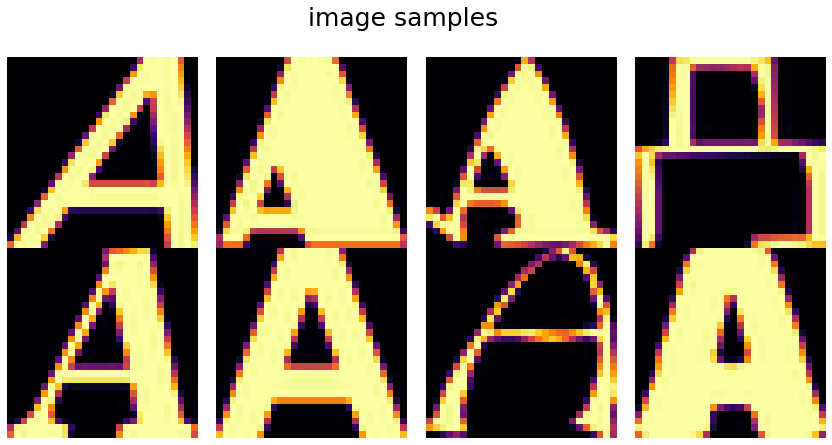

In [9]:
images=train_ds.take(1)
samples = [x for x in images]
batch_size = samples[0].shape[0]
width = samples[0].shape[1]
height = samples[0].shape[2]
channels = samples[0].shape[3]
shape = (width, height, channels)

print('batch size:    ',batch_size)
print('width, hieght: ',width, ',' ,height)
print('channels:      ',channels)
plot_samples(samples[0], title = 'image samples')


## summary
I input 1764 train images and 108 test images of letter A of different fonts with
- batchsize 128
- size 28x28 pixels
- grayscale

# Autoencoder

In [175]:


# Set the hyperparameters
latent_dim = 8
epochs = 300

# Define the encoder model
inputs = Input(shape=(width*height,))
encoded = Dense(128, activation=LeakyReLU(alpha=0.1))(inputs)
encoded = Dense(64, activation=LeakyReLU(alpha=0.1))(encoded)
encoded = Dropout(0.1)(encoded)
encoded = Dense(latent_dim, activation=LeakyReLU(alpha=0.1))(encoded)
encoder_model = Model(inputs, encoded)

# Define the decoder model
encoded_inputs = Input(shape=(latent_dim,))
decoded = Dense(64, activation=LeakyReLU(alpha=0.1))(encoded_inputs)
decoded = Dense(128, activation=LeakyReLU(alpha=0.1))(decoded)
decoded = Dropout(0.1)(decoded)
decoded = Dense(width*height, activation='tanh')(decoded)
decoder_model = Model(encoded_inputs, decoded)

# Define the full model as the combination of the encoder and decoder models
full_model = Model(inputs, decoder_model(encoder_model(inputs)))
full_model.compile(optimizer=RMSprop(lr=0.01),
                   loss='binary_crossentropy',
                   metrics=['accuracy'])


In [176]:
from tensorflow.keras.callbacks import EarlyStopping,  LambdaCallback

early_stop = EarlyStopping(monitor='val_loss',
                           mode='min', 
                           verbose=1, 
                           patience=200, baseline=0.2, restore_best_weights=True)

#stop_on_val_loss = LambdaCallback(on_epoch_end=lambda epoch, logs: 
#                                   early_stop.on_epoch_end(epoch, logs) if logs.get('val_loss') < 0.4 else None)


In [ ]:
# Train the model
history = full_model.fit(X_train_flat, X_train_flat,
                         shuffle=True,
                         epochs=epochs,
                         batch_size=batch_size,
                         validation_split=0.2,
                         callbacks=[early_stop])

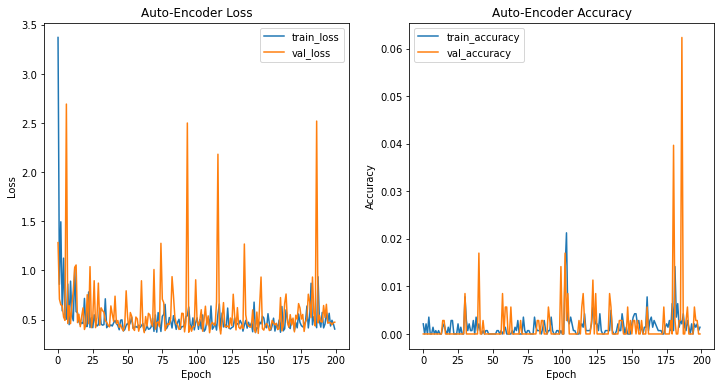

In [178]:
plot_model_history(history, model = 'Auto-Encoder')

### visualize image of different latent dimension

1/1 [==============================] - 0s 20ms/step


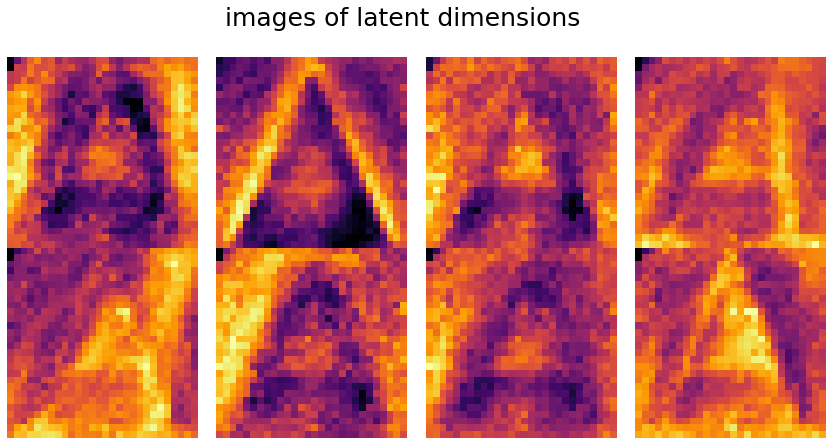

In [179]:
images_ld = []
for i in range(latent_dim):
    z = np.ones(latent_dim).copy()
    z[i] = -1 
    z = np.array([z])
    
    # Use the decoder model to generate a reconstructed image from the latent vector
    reconstructed_image = decoder_model.predict(z)
    reconstructed_image = reconstructed_image.reshape((height, width)).copy()
    #reconstructed_image = (reconstructed_image * 255).astype(np.uint8)
    #plt.imshow(reconstructed_image)
    #plt.show()
    
    images_ld.append(reconstructed_image)

plot_samples(images_ld, title = 'images of latent dimensions')


# Train, Test performance

#### train image encode and generation

In [180]:
X_viz = X_train_flat[(np.random.rand(8)*len(X_train_flat)).astype(int)]
z = encoder_model.predict(X_viz)

reconstructed_image = decoder_model.predict(z)
reconstructed_image = reconstructed_image.reshape((8,height, width)).copy()

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 22ms/step


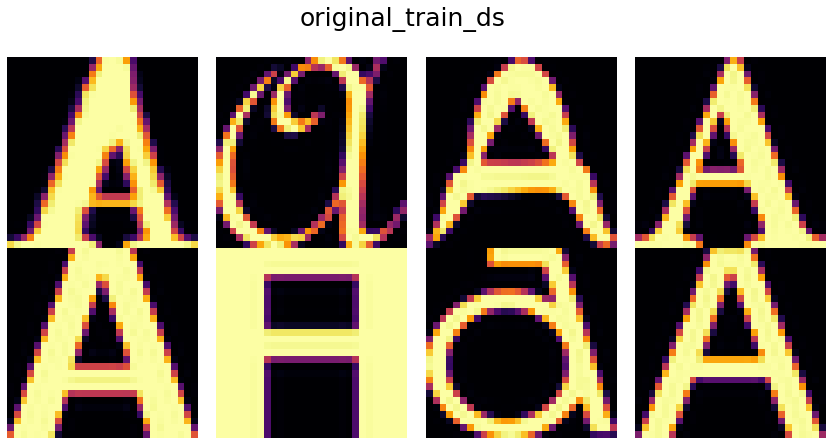

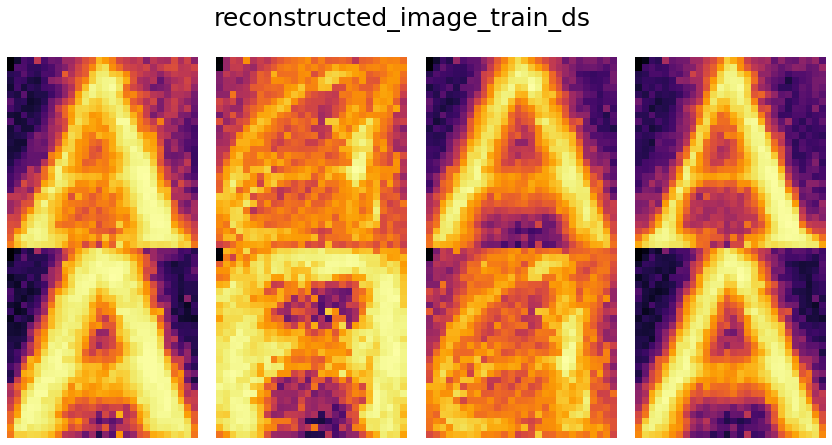

In [181]:
X_viz = X_train_flat[(np.random.rand(8)*len(X_train_flat)).astype(int)]
z = encoder_model.predict(X_viz)

reconstructed_image = decoder_model.predict(z)
reconstructed_image = reconstructed_image.reshape((8,height, width)).copy()

plot_samples(X_viz.reshape((8,height, width)), title = 'original_train_ds')
plot_samples(reconstructed_image, title = 'reconstructed_image_train_ds')

#### test image encode and generation

1/1 [==============================] - 0s 25ms/step


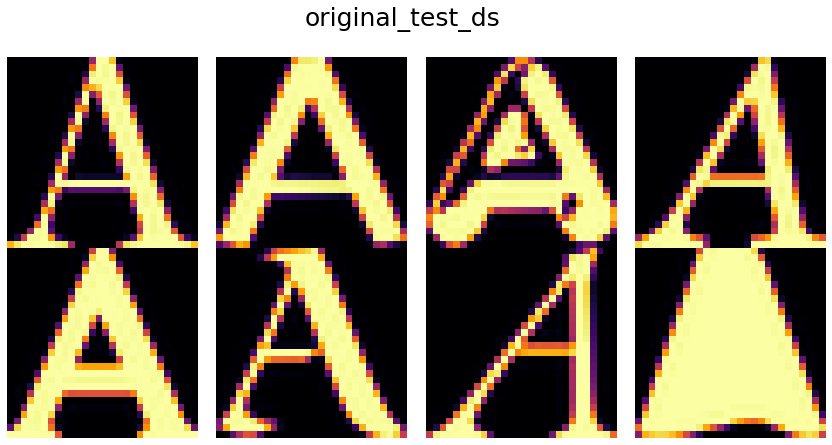

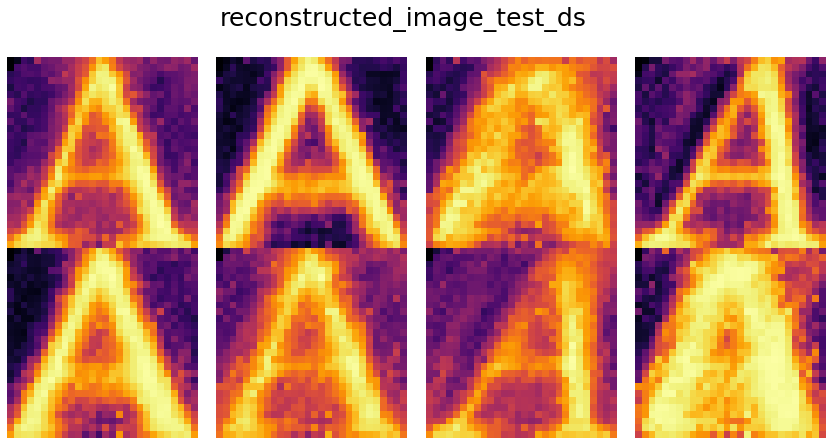

In [182]:
X_viz = X_test_flat[(np.random.rand(8)*len(X_test_flat)).astype(int)]
z = encoder_model.predict(X_viz)

reconstructed_image = decoder_model.predict(z)
reconstructed_image = reconstructed_image.reshape((8,height, width)).copy()

plot_samples(X_viz.reshape((8,height, width)), title = 'original_test_ds')
plot_samples(reconstructed_image, title = 'reconstructed_image_test_ds')

#### MSE evalution

In [218]:
z = encoder_model.predict(X_test_flat)
reconstructed_image_test = decoder_model.predict(z)

test_MSE = standardized_MSE(X_test_flat, reconstructed_image_test)

z = encoder_model.predict(X_train_flat)
reconstructed_image_train = decoder_model.predict(z)

train_MSE = standardized_MSE(X_train_flat, reconstructed_image_train)

print(f'For taining data, the MSE per image per pixel is {train_MSE}')
print(f'For testing data, the MSE per image per pixel is {test_MSE}')

56/56 [==============================] - 0s 3ms/step
For taining data, the MSE per image per pixel is 0.13908622148902078
For testing data, the MSE per image per pixel is 0.14331374164791785


In [217]:
encoder_model.save('encoder_model.h5')
decoder_model.save('decoder_model.h5')

## Summary
We built a Auto-Encoder for letter A of different fonts based on NoMNIST data and the summary of our best model is as follows:
* encoder 128-64 Dense leaky-relu model
* decoder 64-128 Dense leaky-relu model
* Combined with tanh activation layer
* The model learnt capital letter A with tilt as well as shape variation
* Due to insufficient lower case letter a, the model poorly fit these images
* The MSE per image per pixel is around 0.14 for both train and test dataset. No overfitting observed
* One can improve the model by further training as well as expand images with lower case a.

# Variational auto-encoder 

In [265]:
from keras.layers import Lambda, Input, Dense
from keras import backend as K
from keras.losses import mse, binary_crossentropy


In [344]:
def sampling(args):
    """
    Transforms parameters defining the latent space into a normal distribution.
    """
    # Need to unpack arguments like this because of the way the Keras "Lambda" function works.
    mu, log_sigma = args
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=tf.shape(mu))
    sigma = K.exp(log_sigma)
    return mu + K.exp(0.5 * sigma) * epsilon

In [345]:
batch_size = 128
latent_dim = 8

# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=(height*width, ), name='encoder_input')
x = Dense(256, activation='relu')(inputs)


z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

z = Lambda(sampling, name='z')([z_mean, z_log_var])
# z is now one n dimensional vector representing the inputs 
encoder_model = Model(inputs, [z_mean, z_log_var, z], name='encoder')

In [347]:
# build decoder model
latent_inputs = Input(shape=(latent_dim,),)
x = Dense(hidden_dim, activation='relu')(latent_inputs)
outputs = Dense(height*width, activation='sigmoid')(x)

decoder_model = Model(latent_inputs, outputs, name='decoder')


# instantiate VAE model
outputs = decoder_model(encoder_model(inputs)[2])
vae_model = Model(inputs, outputs, name='vae_mlp')

In [348]:
# define reconstruction loss and KL-divergence loss. Include both as total vae loss
reconstruction_loss = binary_crossentropy(inputs, outputs)
reconstruction_loss *= height*width

kl_loss = 0.5 * (K.exp(z_log_var) - (1 + z_log_var) + K.square(z_mean))
kl_loss = K.sum(kl_loss, axis=-1)

total_vae_loss = K.mean(reconstruction_loss + kl_loss)

In [349]:
vae_model.add_loss(total_vae_loss)

vae_model.compile(optimizer='rmsprop',metrics=['accuracy'])
    
vae_model.summary()

Model: "vae_mlp"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 784)]        0           []                               
                                                                                                  
 encoder (Functional)           [(None, 8),          205072      ['encoder_input[0][0]']          
                                 (None, 8),                                                       
                                 (None, 8)]                                                       
                                                                                                  
 decoder (Functional)           (None, 784)          203792      ['encoder[0][2]']                
                                                                                            

In [ ]:
history = vae_model.fit(X_train_flat,
              X_train_flat,
              epochs=500,
              batch_size=batch_size,
                        validation_split=0.2,
                         callbacks=[early_stop])
                        

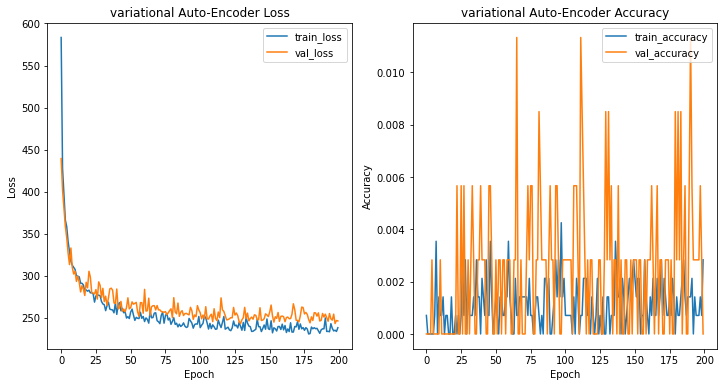

In [357]:
plot_model_history(history, model = 'variational Auto-Encoder')

#### images of latent dimensions

1/1 [==============================] - 0s 18ms/step


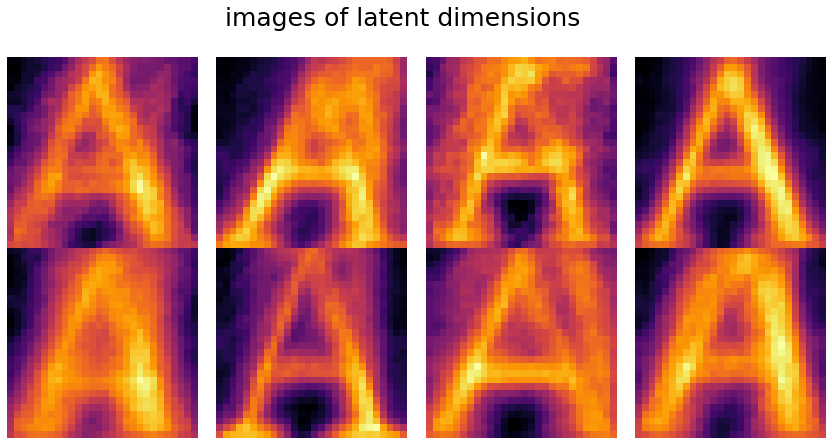

In [356]:
images_ld = []
for i in range(latent_dim):
    z = np.zeros(latent_dim).copy()
    z[i] = 1 
    z = np.array([z])
    
    # Use the decoder model to generate a reconstructed image from the latent vector
    reconstructed_image = decoder_model.predict(z)
    reconstructed_image = reconstructed_image.reshape((height, width)).copy()
    
    images_ld.append(reconstructed_image)

plot_samples(images_ld, title = 'images of latent dimensions')


## Train, Test performance
#### train data generation

1/1 [==============================] - 0s 28ms/step


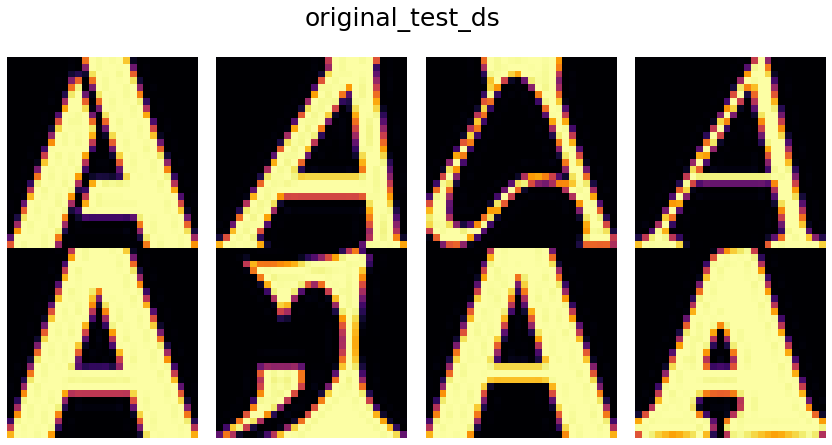

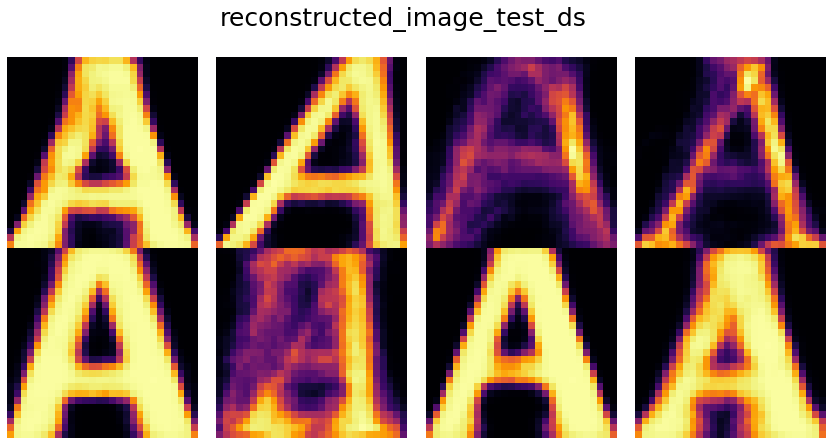

In [377]:
X_viz = X_train_flat[(np.random.rand(8)*len(X_train_flat)).astype(int)]
z = encoder_model.predict(X_viz)

reconstructed_image = decoder_model.predict(z[2])
reconstructed_image = reconstructed_image.reshape((8,height, width)).copy()

plot_samples(X_viz.reshape((8,height, width)), title = 'original_test_ds')
plot_samples(reconstructed_image, title = 'reconstructed_image_test_ds')

1/1 [==============================] - 0s 31ms/step


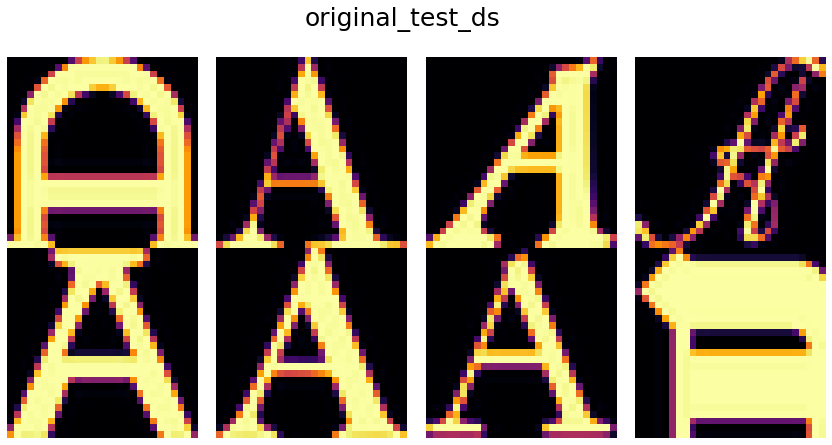

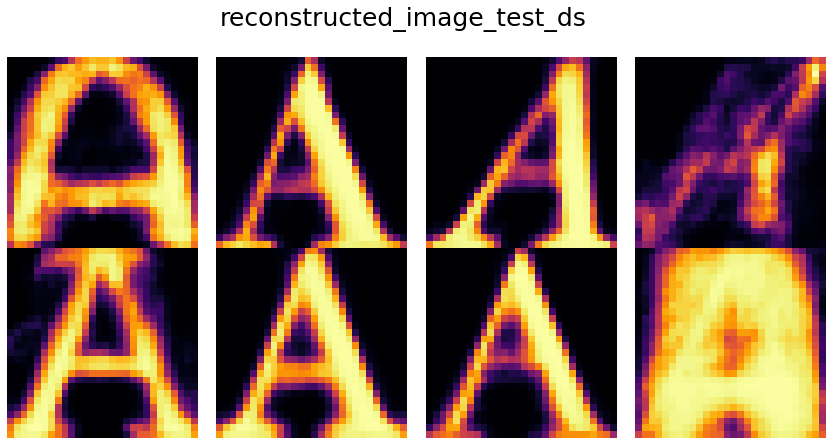

In [380]:
X_viz = X_test_flat[(np.random.rand(8)*len(X_test_flat)).astype(int)]
z = encoder_model.predict(X_viz)

reconstructed_image = decoder_model.predict(z[2])
reconstructed_image = reconstructed_image.reshape((8,height, width)).copy()

plot_samples(X_viz.reshape((8,height, width)), title = 'original_test_ds')
plot_samples(reconstructed_image, title = 'reconstructed_image_test_ds')

In [358]:
z = encoder_model.predict(X_test_flat)[2]
reconstructed_image_test = decoder_model.predict(z)

test_MSE = standardized_MSE(X_test_flat, reconstructed_image_test)

z = encoder_model.predict(X_train_flat)[2]
reconstructed_image_train = decoder_model.predict(z)

train_MSE = standardized_MSE(X_train_flat, reconstructed_image_train)

print(f'For taining data, the MSE per image per pixel is {train_MSE}')
print(f'For testing data, the MSE per image per pixel is {test_MSE}')

56/56 [==============================] - 0s 2ms/step
For taining data, the MSE per image per pixel is 0.05014372085994262
For testing data, the MSE per image per pixel is 0.06031763562629913


## Summary
We built a Variational Autoencoder for letter A of different fonts based on NoMNIST data and the summary of my best model is as follows:

* encoder 256 Dense relu model with a final Dense layer for the mean and log-variance of the latent variable
* decoder 256 Dense relu model
* Combined with sigmoid activation layer
* The model learnt capital letter A with tilt as well as shape variation
* The KL-divergence loss term was added to the reconstruction loss in the objective function
* The model achieved a lower reconstruction loss than the previous Autoencoder with MSE per image per pixel around 0.05 and 0.06 for train and test dataset
* One can further improve the model by hyperparameter tuning, trying different architectures or increasing the size of the dataset.

# GANs generator

In [10]:
def make_discriminator():
    
    model = Sequential()
    
    model.add(Flatten(input_shape=shape))
    model.add(Dense((width * height * channels), input_shape=shape))
    
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(int((width * height * channels)/2)))
    model.add(Dropout(0.1))
    
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    return model 

In [11]:
disc = make_discriminator()
disc.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 784)               615440    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 784)               0         
                                                                 
 dense_1 (Dense)             (None, 392)               307720    
                                                                 
 dropout (Dropout)           (None, 392)               0         
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 392)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 3

In [12]:
def make_generator():
    
    model = Sequential()
    
    # layer 1 
    model.add(Dense(256, input_shape=(1, 1, 8)))
    model.add(LeakyReLU(alpha=0.2))  # using LeakyReLU 
    model.add(BatchNormalization(momentum=0.8))  # using BatchNormalization 
    # layer 2
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    
    # agg layer
    model.add(Dense(width  * height * channels, activation='tanh'))
    model.add(Reshape((width, height, channels)))    
    return model

In [13]:
gen = make_generator()
gen.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 1, 1, 256)         2304      
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 1, 1, 256)         0         
                                                                 
 batch_normalization (BatchN  (None, 1, 1, 256)        1024      
 ormalization)                                                   
                                                                 
 dense_4 (Dense)             (None, 1, 1, 512)         131584    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 1, 1, 512)         0         
                                                                 
 batch_normalization_1 (Batc  (None, 1, 1, 512)        2048      
 hNormalization)                                      

In [14]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [15]:
def generator_loss(Xhat):
    return cross_entropy(tf.ones_like(Xhat), Xhat)
def discriminator_loss(X, Xhat):
    real_loss = cross_entropy(tf.ones_like(X), X)
    fake_loss = cross_entropy(tf.zeros_like(Xhat), Xhat)
    total_loss = 0.5*(real_loss + fake_loss)
    return total_loss

In [16]:
learning_rate = 0.0002

generator_optimizer = tf.keras.optimizers.Adam(lr = 0.0002, beta_1 = 0.5, beta_2 = 0.999 )

discriminator_optimizer = tf.keras.optimizers.Adam(lr = 0.0002, beta_1 = 0.5, beta_2 = 0.999 )

In [17]:
@tf.function
def train_step(X):
    
    #random samples it was found if you increase the  stander deviation, you get better results 
    z= tf.random.normal([BATCH_SIZE, 1, 1, latent_dim])
      # needed to compute the gradients for a list of variables.
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        #generated sample 
        xhat = generator(z, training=True)
        #the output of the discriminator for real data 
        real_output = discriminator(X, training=True)
        #the output of the discriminator for fake data
        fake_output = discriminator(xhat, training=True)
        
        #loss for each 
        gen_loss= generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
      # Compute the gradients for gen_loss and generator
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    # Compute the gradients for gen_loss and discriminator
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    # Ask the optimizer to apply the processed gradients
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

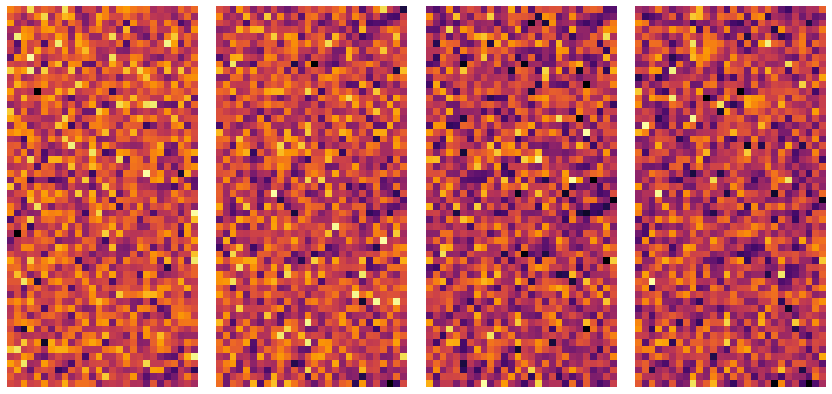

In [18]:
generator= make_generator()
BATCH_SIZE=20

latent_dim=8
noise = tf.random.normal([BATCH_SIZE, 1, 1, latent_dim])
Xhat=generator(noise,training=False)
plot_samples(Xhat)

In [ ]:
epochs=400

discriminator=make_discriminator()

generator= make_generator()

for epoch in range(epochs):
    
    #data for the true distribution of your real data samples training ste
    start = time.time()
    
    for X in tqdm(normalized_ds, desc=f"epoch {epoch+1}", total=len(normalized_ds)):
        train_step(X)
    
    if epoch % 100 ==1:
        noise = tf.random.normal([BATCH_SIZE, 1, 1, latent_dim])
        Xhat=generator(noise,training=False)
        X=[x for x in normalized_ds]
        print("orignal images")
        plot_samples(X[0])
        print("generated images")
        plot_samples(Xhat)
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

In [ ]:
images_ld = []
for i in range(latent_dim):
    z = np.zeros(latent_dim).copy()
    z[i] = 1 
    z = np.array([z])
    
    # Use the decoder model to generate a reconstructed image from the latent vector
    reconstructed_image = decoder_model.predict(z)
    reconstructed_image = reconstructed_image.reshape((height, width)).copy()
    
    images_ld.append(reconstructed_image)

plot_samples(images_ld, title = 'images of latent dimensions')

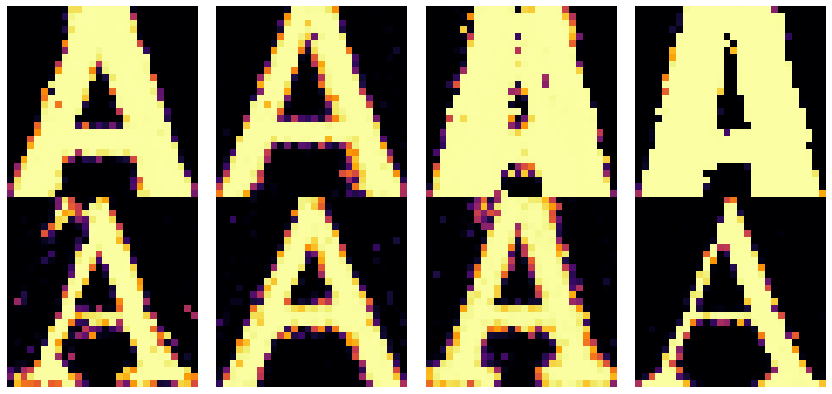

In [26]:
BATCH_SIZE=20

latent_dim=8
noise = tf.random.normal([BATCH_SIZE, 1, 1, latent_dim])
Xhat=generator(noise,training=False)
plot_samples(Xhat)

elements from 0 to 0 is set to -1


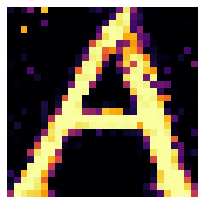

elements from 0 to 1 is set to -1


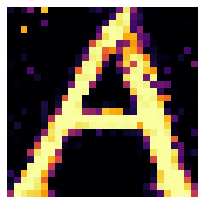

elements from 0 to 2 is set to -1


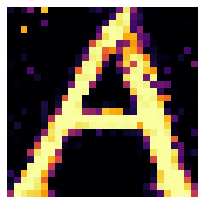

elements from 0 to 3 is set to -1


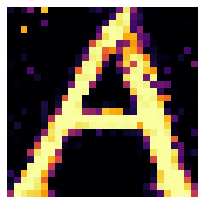

elements from 0 to 4 is set to -1


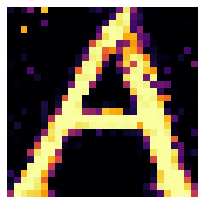

elements from 0 to 5 is set to -1


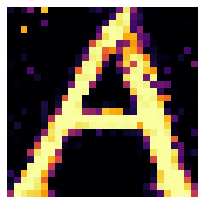

elements from 0 to 6 is set to -1


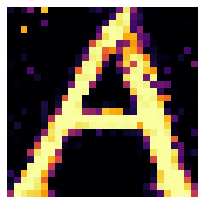

elements from 0 to 7 is set to -1


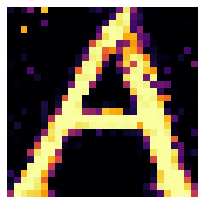

In [25]:
# input consists of noise vectors
z=np.ones( (1, 1, 1, latent_dim))
for n in range(8):

    z[0, 0, 0, 0:1*n]=1

    Xhat=generator(z,training=False)
    print("elements from 0 to {} is set to -1".format(1*n))
    plot_samples(Xhat)

## GANs Summary 
In my model, GANs successfully generated images of letter A. However, with the limitation in dataset, the model can only learn around 3 forms of shape A. One can expand the latent dimension and modify the dataset of images to enable GANs to learn more fonts.

# Summary
I built unsupervised Deep Learning models including auto-encoder, variational auto-encoder, and GANs to generate letter A images of different fonts based on NotMNIST dataset. 
* All models can only generate acceptable images with capital letter A with tilt or diffent width.
* For auto-encoder and variational auto-encoder, when coded with lower case letter a, the models decoded poorly
* In terms of MSE, variational auto-encoder out perform auto-encoder for 0.05 to 0.14 per image per pixel